# Crop-Land Allocation in integrated crop-livestock systems (ICLS)

### MGSC 662 - Decision Analytics taught by Prof. Javad Nasiry

##### Co-Authors : Hugo Guideau, Al Cheaito, Vasilis Christopoulos, Tirth Baldia, Rafael Chantres

In [4]:
import gurobipy as gb
from gurobipy import *
import numpy as np
import pandas as pd
from random import random

#### III.2. Variables and Notations (introduction of fields)

Let $J = \{0, ..., 11\}$ the studied crops, $K = \{0, ..., 5\}$ the rotation's years and $K' = K \backslash \{5\}$. Let $V = I \times J \times K$.

We use now as an input the data from the census of agriculture of Canada from 2021. It allows us to have precise numbers and a better geographical granularity.

##### a. Fields definition

The grid is divided in areas that we will call each $i$. Thus, let $I = \{0, ..., N_{areas}\}$ the set of indices of our areas.

In each of these areas, we segment it again by fields. Let $F_i$ be the set of fields in area $i$, and $f_i \in F_i$ the fields themselves.

As there is no data available on the fields themselves, let's give a random surface to each of them, following the distribution given by the study of Lesiv et al. (2018) for Canada.

|Field Type|Surface (in ha)|Distribution (in %)|
|----------|---------------|-------------------|
|Very Small|<0.64          |4                  |
|Small     |0.64 - 2.56    |5                  |
|Medium    |2.56 - 16      |19                 |
|Large     |16 - 100       |61                 |
|Very Large|>100           |11                 |

Let's note $S_{f_i}$ the surface of field $f_i$.

##### b. Crop on crop allocation

To modelize the succession of choice of crop between years, we introduce the following graph for each field $f_i$:

$$ G_{f_i} = (X_{f_i}, V_{f_i})$$

To simplify the notation, we avoid to add an extra ${f_i}$ index and note each vertex of this graph: $\forall (j, k) \in J \times K, j_k = (j, k)$.

The edges are defined by $x_{j_k, l_m}$ as the decision of planting crop $l$ in year $m$ knowing that crop $j$ in year $k$ has been harvested in field $f_i \in F_i$.

We consider that the edges are only defined year on year (we respect the chronological order), which leads to the following constraints:

$$ \forall j_k, l_m \in (J \times K)^2, x_{j_k, l_m} = 0 \text{ if } m \neq k+1 \text{ or } (k,m) \neq (5,0)$$

For the rest of the study, we will simplify the size of X to the following: $X_{f_i} \in \times J^2 \times K$ as for each year $k$, we need to assess if we take the path between each couple $(j,l) \in J^2$. Considering that all edges from k to k + 1 can be assigned to year k, we can write in a simple form: 

$$ \forall j, l, k \in J^2 \times K', x_{j_k, l_{k+1}} = x_{j,l}^k$$

$$ \forall j, l \in J^2, x_{j_5, l_0} = x_{j,l}^5$$

Thus, we have now:

$$ \forall i \in I, \forall f_i \in F_i, X_{f_i} = (x_{j,l}^k)$$

As a selection term, it means that for one year $k$, one field can have only one crop planted, leading to the following degree constraint:

$$ \forall i \in I, \forall f_i \in F_i, \forall k \in K, \sum_{j, l \in J^2} x_{j,l}^k = 1$$

Here follows the graph expected for each field $f_i$:

In [5]:
# Define the data

J = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Crops = [
    "Spring Wheat",
    "Winter Wheat",
    "Barley",
    "Oats",
    "Rye",
    "Corn",
    "Canola",
    "Soybeans",
    "Peas",
    "Lentils",
    "Grass",
    "Corn Silage",
]
K = [0, 1, 2, 3, 4, 5]

# Crop needs

uptake = [
    [85, 32, 73, 9],     # Spring Wheat
    [67, 30, 70, 10],    # Winter Wheat
    [111, 45, 106, 13],  # Barley
    [116, 40, 145, 13],  # Oats
    [92, 45, 130, 15],   # Rye
    [153, 63, 128, 15],  # Corn
    [112, 52, 81, 19],   # Canola
    [180, 31, 129, 12],  # Soybeans
    [153, 43, 136, 12],  # Peas
    [92, 25, 76, 9],     # Lentils
    [102, 30, 130, 13],  # Grass
    [156, 63, 201, 13],  # Corn Silage
]

removal = [
    [60, 23, 18, 5],     # Spring Wheat
    [52, 25, 17, 7],     # Winter Wheat
    [77, 34, 26, 7],     # Barley
    [61, 25, 18, 5],     # Oats
    [58, 24, 20, 5],     # Rye
    [97, 44, 27, 6],     # Corn
    [68, 37, 18, 11],    # Canola
    [135, 29, 49, 4],    # Soybeans
    [117, 35, 35, 6],    # Peas
    [62, 18, 33, 5],     # Lentils
    [102, 30, 130, 13],  # Grass
    [156, 63, 201, 13],  # Corn Silage
]

# Translate lb/acre to kg/ha

uptake = np.array(uptake) * 1.12085
removal = np.array(removal) * 1.12085

list_crops = [
    "BARLEY_M",
    "OTTAME_M",
    "CANOLA_M",
    "CORNGR_M",
    "CORNSI_M",
    "DFPEAS_M",
    "LENTIL_M",
    "OATS_M",
    "SOYBNS_M",
    "TOTRYE_M",
    "WHTSPG_M",
    "WHTWIN_M"
]

/var/folders/0y/lj9prt316tz8d_f5mpgwdgp80000gn/T/ipykernel_39261/2599811146.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: Polygon(g[["X", "Y"]].values))


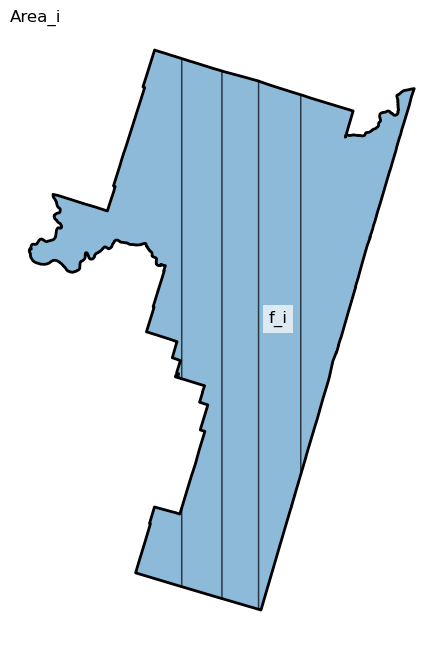

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import split

# =====================================================================
# 1. FUNCTIONS
# =====================================================================

def cut_polygon_by_vertical_line(poly, xcoord):
    """
    Split polygon using a vertical line at x = xcoord.
    """
    minx, miny, maxx, maxy = poly.bounds
    cut_line = LineString([(xcoord, miny - 10_000), (xcoord, maxy + 10_000)])
    return split(poly, cut_line)


def find_x_for_target_area(poly, target_area, tol=1e-6):
    """
    Find x such that area(left_of_x) = target_area using binary search.
    """
    minx, miny, maxx, maxy = poly.bounds
    low, high = minx, maxx

    for _ in range(100):
        mid = (low + high) / 2
        result = cut_polygon_by_vertical_line(poly, mid)

        # Compute area of pieces left of the cut line
        left_area = sum(g.area for g in result.geoms if g.centroid.x < mid)

        if abs(left_area - target_area) < tol:
            return mid

        if left_area < target_area:
            low = mid
        else:
            high = mid

    return mid


def equal_area_splits(poly, num_parts):
    total_area = poly.area
    part_area = total_area / num_parts

    # Compute vertical cut locations
    cuts = [find_x_for_target_area(poly, part_area * i) for i in range(1, num_parts)]

    pieces = [poly]

    # Apply cuts sequentially
    for x in cuts:
        new_pieces = []
        for p in pieces:
            result = cut_polygon_by_vertical_line(p, x)
            new_pieces.extend([g for g in result.geoms if g.area > 1e-6])
        pieces = new_pieces

    return pieces


# =====================================================================
# 2. READ CSV POLYGON DATA
# =====================================================================

# Example CSV format:
# poly_id, x, y
# 1, 0, 0
# 1, 5, 0
# 1, 5, 10
# 1, 0, 10
# (etc.)

csv_path = "/Users/hugoguideau/Documents/Cours/McGill/MGSC 662/polygon_vertices_alberta.csv"
df = pd.read_csv(csv_path)

# Create polygons grouped by poly_id
polygons = (
    df.groupby("CCSUID")
      .apply(lambda g: Polygon(g[["X", "Y"]].values))
)

# Convert to GeoSeries
polys = gpd.GeoSeries(polygons)

# =====================================================================
# 3. SELECT ONE POLYGON TO PLOT AND SPLIT
# =====================================================================

poly_id_to_plot = polys.index[0]   # pick the first polygon in the CSV
poly = polys.loc[poly_id_to_plot]

# Split polygon
num_parts = 5
equal_parts = equal_area_splits(poly, num_parts)

# Convert split pieces to GeoDF
gdf = gpd.GeoDataFrame(geometry=equal_parts)

# =====================================================================
# 4. PLOT
# =====================================================================

# Original polygon area
Area_i = poly.area

fig, ax = plt.subplots(figsize=(8, 8))

# Plot original boundary
gpd.GeoDataFrame(geometry=[poly]).boundary.plot(ax=ax, color="black", linewidth=2)

# Plot sub-polygons
gdf.plot(ax=ax, alpha=0.5, edgecolor="black")

# Label total area outside polygon
minx, miny, maxx, maxy = poly.bounds
offset_x = minx - (maxx - minx) * 0.05
offset_y = maxy + (maxy - miny) * 0.05

ax.text(
    offset_x,
    offset_y,
    f"Area_i",
    fontsize=12
)

# Label one sub-polygon
chosen_sub = equal_parts[2]     # choose the third split region
centroid = chosen_sub.centroid

ax.text(
    centroid.x,
    centroid.y,
    "f_i",
    ha="center",
    va="center",
    fontsize=12,
    color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

ax.axis('off')
ax.set_aspect("equal")
plt.show()

# =====================================================================
# END
# =====================================================================

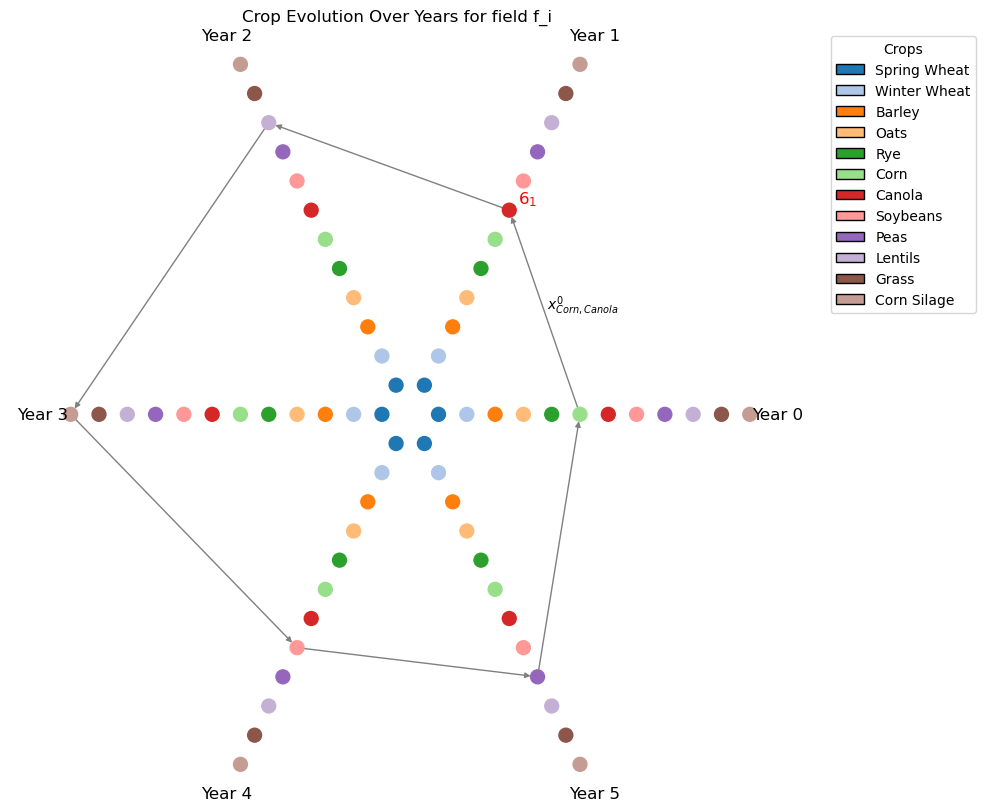

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

num_crops = len(Crops)
num_years = len(K)
radius_step = 1  # distance between crops along each year spoke

G = nx.DiGraph()
pos = {}

# Generate a distinct color for each crop
cmap = plt.get_cmap("tab20")  # up to 10 distinct colors
crop_colors = {crop: cmap(i % 12) for i, crop in enumerate(Crops)}

# -----------------------------
# Create positions: radial layout
# Years = circle vertices
# Crops = along spokes
# -----------------------------
for k, year in enumerate(K):
    angle = 2 * np.pi * k / num_years  # angle for this year
    for j, crop in enumerate(Crops):
        r = (j+1) * radius_step  # distance from center along the spoke
        x_0 = r * np.cos(angle)
        y_0 = r * np.sin(angle)
        node_id = crop + f" (Year {year})"
        pos[node_id] = (x_0, y_0)
        
        G.add_node(node_id, value=1000, crop=crop)

# Define the crop harvested per year

Choice = ["Corn (Year 0)", "Canola (Year 1)", "Lentils (Year 2)", "Corn Silage (Year 3)", "Soybeans (Year 4)", "Peas (Year 5)"]

# -----------------------------
# Add edges between consecutive years for each crop
# -----------------------------
for i in range(len(Choice)):
    src = Choice[i]
    dst = Choice[i+1] if i < len(Choice) - 1 else Choice[0]
    G.add_edge(src, dst)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 10))
plt.axis("off")

# Node colors based on crop
node_colors = [crop_colors[G.nodes[n]["crop"]] for n in G.nodes()]

# Node sizes scaled by value
node_sizes = [G.nodes[n]["value"] / 10 for n in G.nodes()]

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    arrows=True,
    arrowsize=8
)

# -----------------------------
# Year labels around circle
# -----------------------------
for k, year in enumerate(K):
    angle = 2 * np.pi * k / num_years
    x_text = (num_crops + 1) * radius_step * np.cos(angle)
    y_text = (num_crops + 1) * radius_step * np.sin(angle)
    plt.text(x_text, y_text, f"Year {year}", ha="center", va="center", fontsize=12)

node_to_label = "Canola (Year 1)"
x, y = pos[node_to_label]

label = r"$6_1$"

# offset by dx, dy
dx, dy = 0.3, 0.2  # tweak as needed
plt.text(
    x + dx,
    y + dy,
    label,
    fontsize=12,
    color="red",
    fontweight="bold"
)

edge_to_label = ("Corn (Year 0)", "Canola (Year 1)")

# get positions
x1, y1 = pos[edge_to_label[0]]
x2, y2 = pos[edge_to_label[1]]

# midpoint of edge
xm, ym = (x1 + x2)/2, (y1 + y2)/2

label = r"$x_{" + "Corn, Canola" + r"}^0$"

# offset
dx, dy = 0.1, 0.1
plt.text(
    xm + dx,
    ym + dy,
    label,
    fontsize=10,
    color="black",
    fontweight="bold"
)

# -----------------------------
# Legend for crop colors
# -----------------------------
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='k', label=crop) for crop, color in crop_colors.items()]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Crops")

plt.title("Crop Evolution Over Years for field f_i")
plt.show()

##### c. Surface allocated per crop

Let's define the surface allocated for crop $j \in J$, in year $k \in K$, in area $i \in I$ with $a_{i,j,k}$. The $a_{i, j, k}$ are related to the fields' surface with:

$$ \forall i, l, k \in (I \times J \times K'), a_{i,l,k+1} = S_{f_i} \times \sum_{j \in J} x_{j,l}^k$$

$$ \forall i, l \in (I \times J), a_{i,l,0} = S_{f_i} \times \sum_{j \in J} x_{j,l}^5$$

On the same fashion, we can note the actual surface allocated on average to each crop as per the 32-10-0359-01 Table from Statistic Canada:
$$\forall (i,j) \in I \times J, A_{i,j}$$

We want to use this as the demand but yet, let's be flexible and ask for each crop to have only 80% of the demand, hence the following constraint:

$$\forall (i,j,k) \in V, a_{i,j,k} \ge 0.8A_{i,j}$$

##### d. Nutrients needs

Now that we have the choices ${x_{j,l}^k}$, we are able to compute what are the amounts of nutrients to bring for each fields.

Let's start with an example. We set ourselves in area 0, and we look at the quantity of nitrogen to bring to crop 0 in year 1 in field $f_0 \in F_0$ , knowing the previous crop harvested from year 0 was crop 2, meaning $x_{0,2}^0 = 1$. Then, the quantity follows the formula:

$$ Q_{N, 0, f_0} = S_{f_0} \times (N(Up)_0 - (N(Up)_2 - N(Re)_2))$$

We can extend this formula to all fields and their graph vertices and to all nutrients $N = \{N, P_2O_5, K_2O, S\}$, having the formula:

$$ \forall (n,i,k) \in (N \times I \times K), Q_{n, k, f_i} = S_{f_i} \times \left(\sum_{j, l \in J^2} x_{j,l}^k \times (n(Up)_l - (n(Up)_j - n(Re)_j))\right) $$

##### e. Decision variables

Let's resume the decision variables:

|Variables          |Description                                    |Type                            |Number                                       |
|-------------------|-----------------------------------------------|--------------------------------|---------------------------------------------|
|$$X_{f_i}$$        |Set of choices of crop, YoY, per field $f_i$   |Integers                        |$$Card(\bigcup_{I} F_i \times J^2 \times K)$$|


##### f. Objective function

Our objective is to limit the need to bring additional nutrients to the field. Thus, our first objective function would be:

$$ \min \sum_{N,K,F_i} Q_{n, k, f_i} $$

##### g. Constraints

|Description                                                                   |Formula                                                        |
|------------------------------------------------------------------------------|---------------------------------------------------------------|
|Yearly allocation of crops has to reach 80% of the actual surface seeded      |$$\forall (i,j,k) \in V, a_{i,j,k} \ge 0.8A_{i,j}$$              |
|Fields degree constraints - every field must be reused                        |$$ \forall i \in I, \forall f_i \in F_i, \forall k \in K, \sum_{j, l \in J^2} x_{j,l}^k = 1$$|


Let's code and see what are the results!

In [8]:
# Divide the areas with their respected fields

A = pd.read_csv("/Users/hugoguideau/Documents/Cours/McGill/MGSC 662/crop_alberta.csv", index_col="CCSUID")
A = A.drop(columns=["CCSNAME","SRUNOM"])

# Change the name of the columns to match the Crops
A.columns = Crops

A.head()

,Spring Wheat,Winter Wheat,Barley,Oats,Rye,Corn,Canola,Soybeans,Peas,Lentils,Grass,Corn Silage
CCSUID,,,,,,,,,,,,
4801003,43167.0,-1.0,20906.0,2091.0,1635.0,-1.0,23237.0,0.0,20137.0,13778.0,10460.0,1631.0
4801008,63724.0,4846.0,40076.0,2946.0,2460.0,-1.0,44214.0,-1.0,31745.0,49957.0,3191.0,-1.0
4802001,35461.0,8392.0,43327.0,1150.0,3287.0,-1.0,43364.0,0.0,17465.0,28351.0,5208.0,7237.0
4802011,54277.0,9021.0,74324.0,3748.0,5972.0,4582.0,65286.0,553.0,17650.0,9572.0,10054.0,12679.0
4802021,44949.0,5216.0,28457.0,1146.0,-1.0,5136.0,33353.0,0.0,12257.0,7899.0,4533.0,2937.0


In [9]:
# Show the row of index = 4801003

for j in J:
    print(A.loc[4801003][Crops[j]])

43167.0
-1.0
20906.0
2091.0
1635.0
-1.0
23237.0
0.0
20137.0
13778.0
10460.0
1631.0


In [10]:
# Breakdown the area into fields following the density given by Lesiv et al.

CCSUID = A.index
Total_areas = A.sum(axis=1)

distribution = [0.04, 0.09, 0.28, 0.89]
surface = [0.64, 2.56, 16, 100]

Fields = {}

for ccs in CCSUID:
    Total_area = Total_areas[ccs]
    scaler = np.sqrt(Total_area) / 10

    Fields[ccs] = {}

    f = 0
    remaining_area = Total_area

    while remaining_area > 0:
        u = random()
        for i in range(len(distribution)):
            if u <= distribution[i]:
                if i == 0:
                    area = surface[i] * random()
                else:
                    area = surface[i-1] + random() * (surface[i] - surface[i-1])

        if u > 0.89:
            area = surface[i] + random() * scaler
            
        if area < remaining_area:
            Fields[ccs][f] = scaler * area
            remaining_area -= scaler * area
        else:
            Fields[ccs][f] = scaler * area
            remaining_area = 0
            
        f += 1

/var/folders/0y/lj9prt316tz8d_f5mpgwdgp80000gn/T/ipykernel_39261/3155669270.py:13: RuntimeWarning: invalid value encountered in sqrt
  scaler = np.sqrt(Total_area) / 10


In [23]:
# Implementation of the model

m = gb.Model("Crop-rotation Optimization - with Fields")

In [24]:
# Decision variables

x = m.addVars(
    [(4801003, f, j, l, k)
                        for f in Fields[4801003]
                        for j in J
                        for l in J
                        for k in K],
    vtype=gb.GRB.BINARY,
    name=lambda tpl: f"x_{ccs}_{f}_{Crops[j]}_{Crops[l]}_{k}"
)

In [25]:
# Computation of the quantities of nutrients to bring

Q = {}
for n in range(len(uptake[0])):
    for f in Fields[4801003]:
        for k in K:
            Q[n, k, 4801003, f] = Fields[4801003][f] * sum(x[4801003, f, j, l, k] * (uptake[l][n] - (uptake[j][n] - removal[j][n])) for j in J for l in J)

In [26]:
# Objective function

m.setObjective(sum(Q[n, k, 4801003, f] for n in range(len(uptake[0])) for k in K for f in Fields[4801003]), GRB.MINIMIZE)

In [27]:
# Add Constraints

m.addConstrs((sum(x[4801003, f, j, l, k] for j in J for l in J) == 1 for f in Fields[4801003] for k in K), name="Selection of crops")
m.addConstrs((sum(x[4801003, f, j, l, k] for j in J) == sum(x[4801003, f, l, j, k+1] for j in J) for f in Fields[4801003] for l in J for k in K if k < len(K) - 1), name="Degree constraints")
m.addConstrs((sum(x[4801003, f, j, l, 5] for j in J) == sum(x[4801003, f, l, j, 0] for j in J) for f in Fields[4801003] for l in J), name="Degree constraints - last year")
m.addConstrs((sum(Fields[4801003][f] * sum(x[4801003, f, j, l, k] for j in J) for f in Fields[4801003]) >= 0.8 * float(A.loc[4801003][Crops[l]]) for l in J for k in K), name="Allocation of crops")

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (3, 0): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,


In [28]:
# Solve the model

m.Params.MIPGap = 1e-3   # stop when gap <= 0.1% (0.001)
m.optimize()

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.001

Optimize a model with 4518 rows, 49248 columns and 196992 nonzeros
Model fingerprint: 0xd43f5d32
Variable types: 0 continuous, 49248 integer (49248 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+03, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 3e+04]
Presolve removed 18 rows and 0 columns
Presolve time: 0.18s
Presolved: 4500 rows, 49248 columns, 184680 nonzeros
Variable types: 0 continuous, 49248 integer (49248 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.278658e+

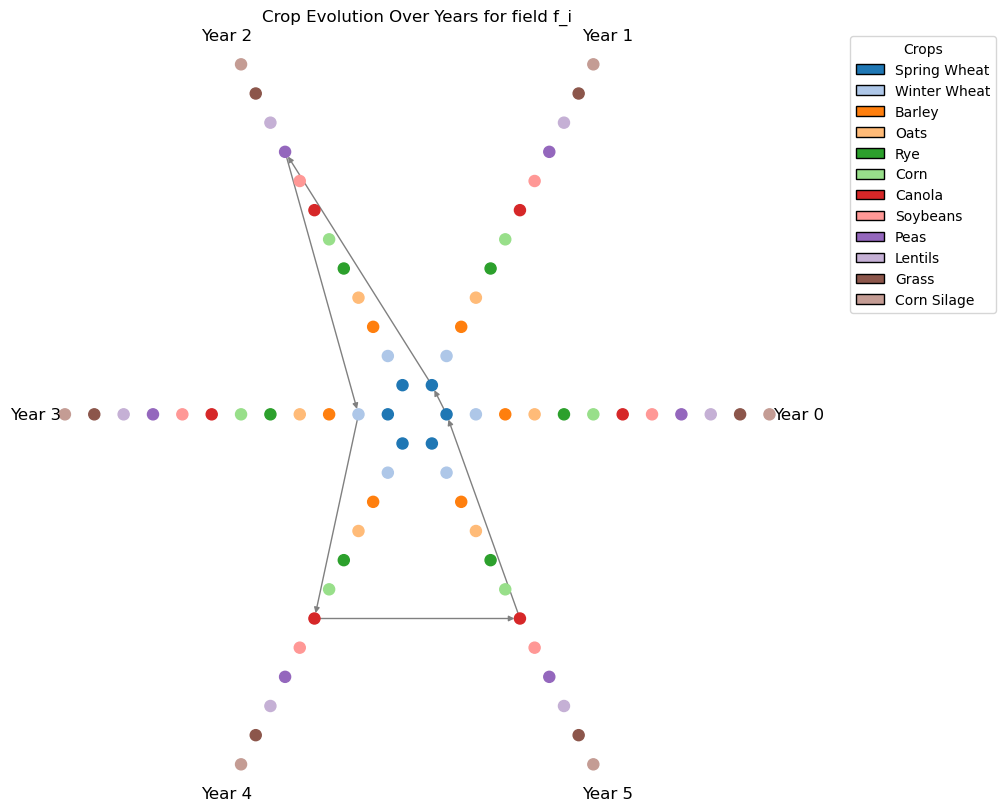

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

num_crops = len(Crops)
num_years = len(K)
radius_step = 1  # distance between crops along each year spoke

G = nx.DiGraph()
pos = {}

# Generate a distinct color for each crop
cmap = plt.get_cmap("tab20")  # up to 10 distinct colors
crop_colors = {crop: cmap(i % 12) for i, crop in enumerate(Crops)}

# -----------------------------
# Create positions: radial layout
# Years = circle vertices
# Crops = along spokes
# -----------------------------
for k, year in enumerate(K):
    angle = 2 * np.pi * k / num_years  # angle for this year
    for j, crop in enumerate(Crops):
        r = (j+1) * radius_step  # distance from center along the spoke
        x_0 = r * np.cos(angle)
        y_0 = r * np.sin(angle)
        node_id = crop + f" (Year {year})"
        pos[node_id] = (x_0, y_0)
        
        G.add_node(node_id, value=Fields[4801003][0], crop=crop)

# -----------------------------
# Add edges between consecutive years for each crop
# -----------------------------
for j in J:
    for l in J:
        for k in K:
            if x[4801003, 0, j, l, k].X > 0:
                src = Crops[j] + f" (Year {k})"
                dst = Crops[l] + f" (Year {k+1})" if k < len(K) - 1 else Crops[l] + " (Year 0)"
                G.add_edge(src, dst)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 10))
plt.axis("off")

# Node colors based on crop
node_colors = [crop_colors[G.nodes[n]["crop"]] for n in G.nodes()]

# Node sizes scaled by value
node_sizes = [G.nodes[n]["value"] / 50 for n in G.nodes()]

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    arrows=True,
    arrowsize=8
)

# -----------------------------
# Year labels around circle
# -----------------------------
for k, year in enumerate(K):
    angle = 2 * np.pi * k / num_years
    x_text = (num_crops + 1) * radius_step * np.cos(angle)
    y_text = (num_crops + 1) * radius_step * np.sin(angle)
    plt.text(x_text, y_text, f"Year {year}", ha="center", va="center", fontsize=12)


# -----------------------------
# Legend for crop colors
# -----------------------------
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='k', label=crop) for crop, color in crop_colors.items()]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Crops")

plt.title("Crop Evolution Over Years for field f_i")
plt.show()

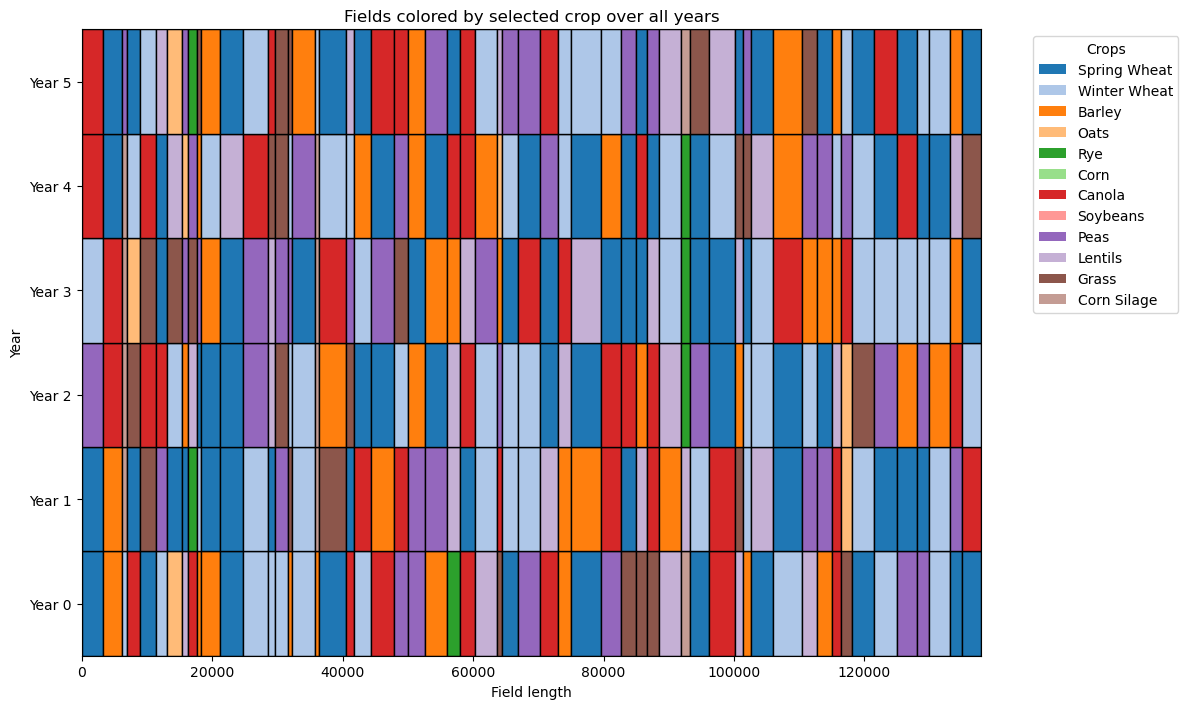

In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

# Generate a distinct color for each crop
cmap = plt.get_cmap("tab20")
crop_colors = {crop: cmap(i % 20) for i, crop in enumerate(Crops)}

fig, ax = plt.subplots(figsize=(12, 1.2 * len(K)))   # height grows with number of years

year_height = 1   # vertical height of each horizontal bar

for k_idx, k in enumerate(K):      # loop over years (K is your year set)
    current_x = 0

    # Loop through fields
    for f, size in Fields[4801003].items():
        # Find which crop is selected for this field in year k
        chosen_crop = None
        for j in J:
            for l in J:
                if x[4801003, f, j, l, k].X == 1:
                    chosen_crop = Crops[j]
                    break
            if chosen_crop:
                break

        # Default color (in case no crop is selected)
        color = crop_colors.get(chosen_crop, "lightgray")

        # Draw the field block at the correct vertical offset (k_idx * year_height)
        rect = Rectangle(
            (current_x, k_idx * year_height),
            size,
            year_height,
            facecolor=color,
            edgecolor="black"
        )
        ax.add_patch(rect)
        current_x += size

# Legend
legend_elements = [Patch(facecolor=color, label=crop) for crop, color in crop_colors.items()]
ax.legend(handles=legend_elements, title="Crops", bbox_to_anchor=(1.05, 1), loc='upper left')

# Axis formatting
ax.set_xlim(0, current_x)
ax.set_ylim(0, len(K) * year_height)
ax.set_yticks([i + year_height/2 for i in range(len(K))])
ax.set_yticklabels([f"Year {k}" for k in K])
ax.set_title("Fields colored by selected crop over all years")
ax.set_xlabel("Field length")
ax.set_ylabel("Year")
ax.grid(False)
ax.axis('on')   # keep axes visible for the year labels

plt.tight_layout()
plt.show()